In [1]:
# Plot test role probes

In [2]:
library(tidyverse)
library(fs)
# library(ggtext)
library(systemfonts)

ws = '/workspace/deliberative-alignment-jailbreaks'

source(paste0(ws, '/r-utils/plots.r'))

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.5.2
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


# Load data

In [3]:
raw_df =
    read_csv(file.path(ws, 'experiments/da-role-analysis/exports/test-role-projections.csv'), trim_ws = FALSE) %>%
    select(., -prompt)

head(raw_df, 1)

Rows: 7936 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): role_space, prompt_key, prompt, token, base_message_type
dbl (5): sample_ix, prob, prompt_ix, token_in_prompt_ix, base_message_ix

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


sample_ix,role_space,prob,prompt_ix,prompt_key,token_in_prompt_ix,base_message_ix,token,base_message_type
<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>
0,system,0.95582,0,basic_no_format,0,0,You,system


# Plots

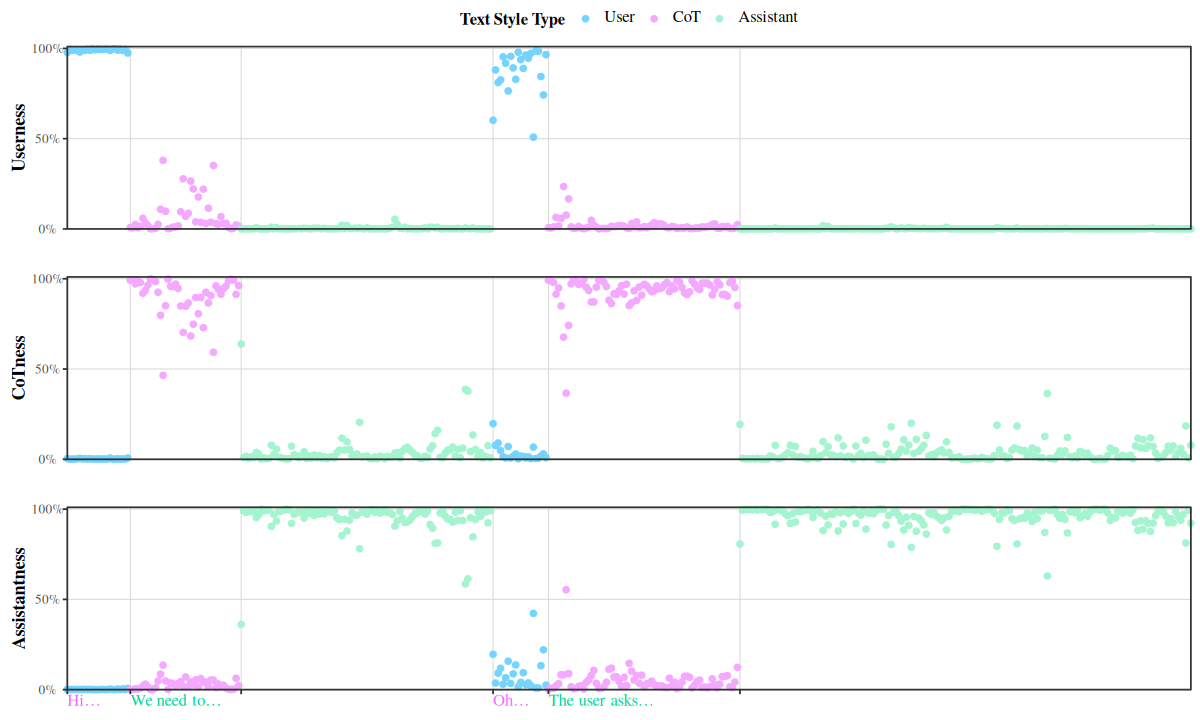

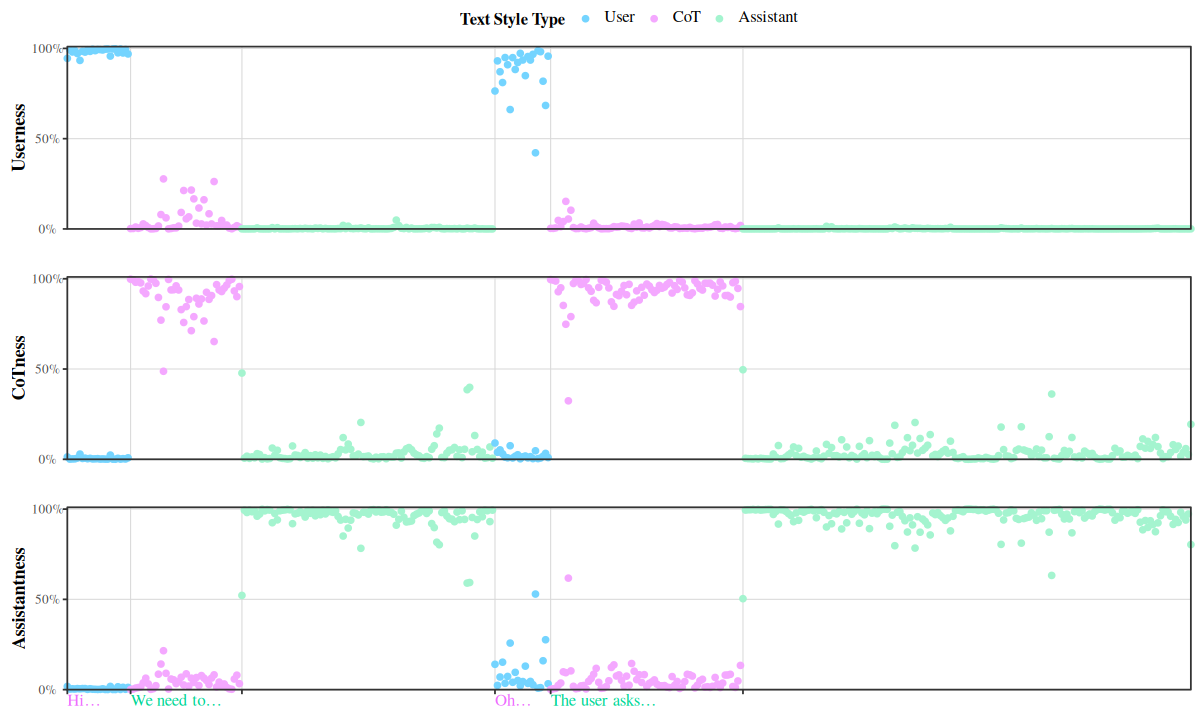

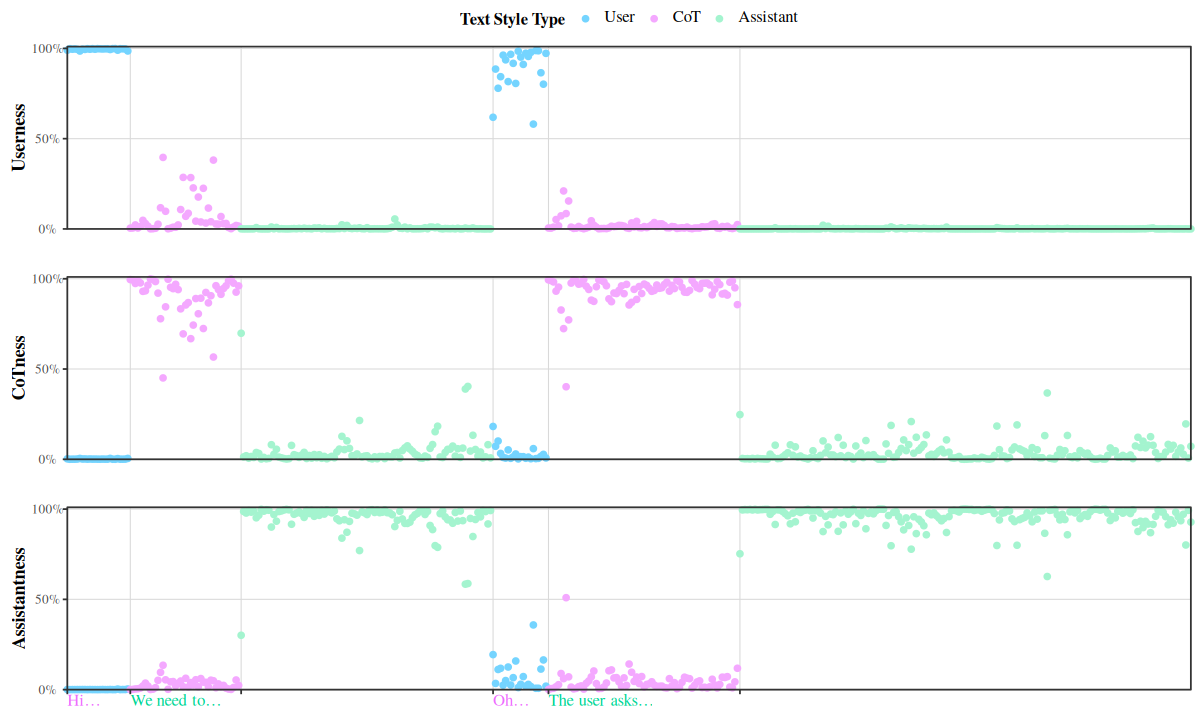

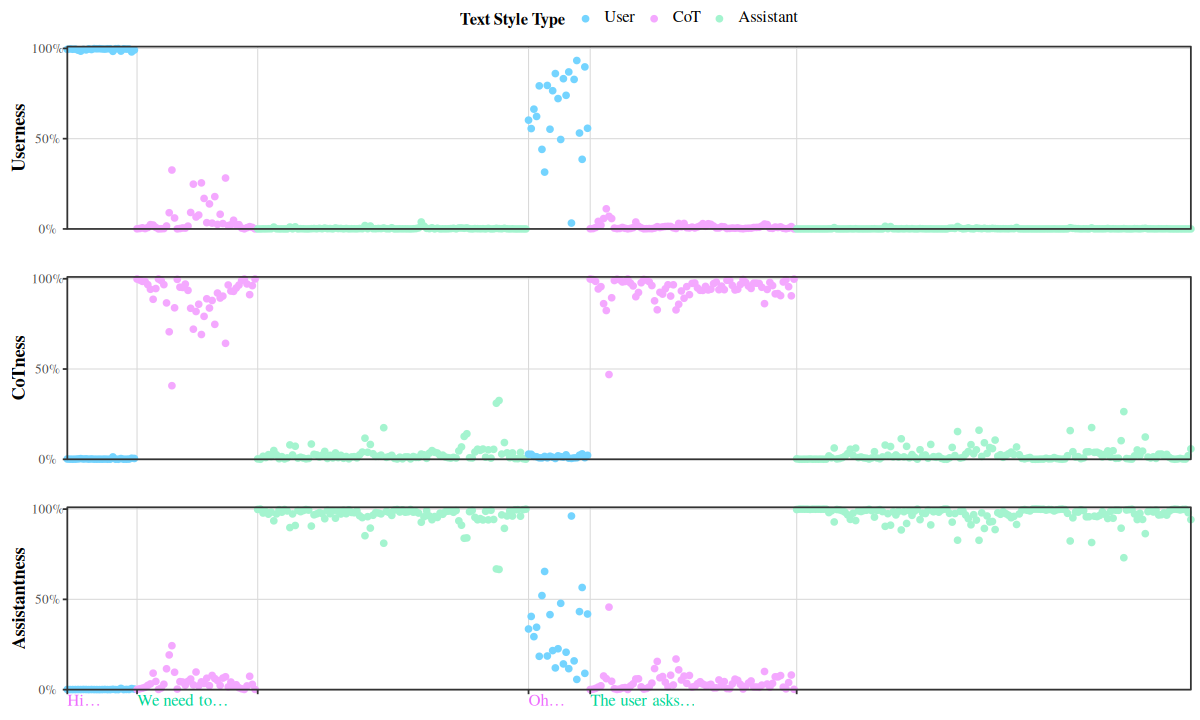

In [ ]:
# Plot
options(repr.plot.width = 10, repr.plot.height = 6)

plot_df =
    raw_df %>%
    group_by(prompt_key, prompt_ix, role_space) %>%
    mutate(
        prob_sma = zoo::rollmean(prob, k = 2, fill = NA, align = 'right', partial = T),
        prob_ewma = zoo::rollapply(
            prob, width = seq_along(prob),
            FUN = function(x) {
                weights = .5^(seq(length(x) - 1, 0))
                sum(x * weights) / sum(weights)
            },
            align = 'right'
        )
    ) %>%
    ungroup() %>%
    mutate(., role_space = fct_relevel(role_space, 'system', 'user', 'assistant-cot', 'assistant-final')) %>%
    mutate(., role_space = recode(role_space,
        'system' = 'Systemness',
        'user' = 'Userness',
        'assistant-cot' = 'CoTness',
        'assistant-final' = 'Assistantness'
    )) %>%
    mutate(., base_message_type = fct_relevel(base_message_type, 'system', 'user', 'cot', 'assistant-final')) %>%
    mutate(., base_message_type = recode(base_message_type,
        'system' = 'System',
        'user' = 'User',
        'cot' = 'CoT',
        'assistant-final' = 'Assistant',
    )) %>%
    filter(base_message_type != 'System') %>%
    filter(role_space != 'Systemness') %>%
    group_by(prompt_key, role_space) %>%
    arrange(., token_in_prompt_ix, .by_group = T) %>%
    mutate(., token_in_prompt_ix = 1:n()) %>%
    ungroup() 

point_colors = c(
  "System" = "#90a1b9", # slate
  "User" = "#74d4ff", # sky
  "CoT" = "#f4a8ff", # fuschia
  "Assistant" = "#a4f4cf"  # emerald
)

text_colors = c(
  "System" = "#62748e", # slate
  "User" = "#00bcff", # sky
  "CoT" = "#ed6bff", # fuschia
  "Assistant" = "#00d492"  # emerald
)


plots = map(group_split(plot_df, prompt_key), function(this_plot_df) {

    # Seg text + index for the start of each consecutive base_message_type segment
    segs =
        this_plot_df %>%
        arrange(prompt_key, prompt_ix, token_in_prompt_ix) %>%
        # Collapse out role_space
        group_by(prompt_ix, token_in_prompt_ix, base_message_type) %>%
        summarize(token = unique(token), .groups = 'drop') %>%
        group_by(prompt_ix) %>%
        mutate(., rleid = consecutive_id(base_message_type)) %>%
        group_by(prompt_ix, rleid, base_message_type) %>%
        arrange(token_in_prompt_ix, .by_group = TRUE) %>%
        summarize(
            .,
            start_ix = first(token_in_prompt_ix),
            # Length of contiguous segment
            start_str = {
                nseg <- dplyr::n()
                k  <- {
                    if (first(base_message_type) == "User") min(1, nseg) 
                    else if (first(base_message_type) == "CoT") min(3, nseg)
                    else min(5, nseg)
                }
                paste0(head(token, k), collapse = "")
            },
            .groups = 'drop'
        ) %>%
        mutate(., start_str = paste0(
            "<span style='color:", text_colors[base_message_type], "'>",
            start_str, "...</span>"
        ))
        
    this_p =
        this_plot_df %>%
        ggplot() +
        geom_point(aes(x = token_in_prompt_ix, y = prob, color = base_message_type)) +
        facet_grid(rows = vars(role_space), switch = 'y') +
        scale_y_continuous(
            labels = scales::percent_format(accuracy = 1),
            limits = c(0, 1),
            expand = expansion(mult = c(0, 0.01)),
            breaks = c(0, .5, 1)
        ) +
        scale_x_continuous(
            breaks = segs$start_ix,
            labels = segs$start_str,
            expand = expansion(mult = c(0, 0))
        ) +
        scale_color_manual(values = point_colors, drop = FALSE) +
        labs(
            title = unique(this_plot_df$prompt_key),
            x = NULL,
            y = NULL,
            color = 'Text Style Type'
        ) +
        coord_cartesian(clip = "off") +
        theme_iclr(base_size = 11) +
        theme(
            legend.position = 'top',
            axis.title.y = ggtext::element_markdown(angle = 90, vjust = 0.5, margin = margin(r = 6)),
            strip.placement = 'outside',
            strip.text.y.left = element_text(angle = 90, face = 'bold'),
            panel.spacing.y = unit(2.0, "lines"),
            axis.text.x = ggtext::element_markdown(size = 10, hjust = 0, angle = 0)
        )

    print(this_p)
})


In [5]:
group_split(plot_df, prompt_key)

sample_ix,role_space,prob,prompt_ix,prompt_key,token_in_prompt_ix,base_message_ix,token,base_message_type,prob_sma,prob_ewma
<dbl>,<fct>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<chr>,<fct>,<dbl>,<dbl>
57,Systemness,0.016680,0,basic_no_format,1,1,Hi,User,0.0299445,0.0223812808
58,Systemness,0.004780,0,basic_no_format,2,1,",",User,0.0107300,0.0135806404
59,Systemness,0.009185,0,basic_no_format,3,1,I'm,User,0.0069825,0.0113828202
60,Systemness,0.004613,0,basic_no_format,4,1,learning,User,0.0068990,0.0079979101
61,Systemness,0.009037,0,basic_no_format,5,1,how,User,0.0068250,0.0085174551
62,Systemness,0.014091,0,basic_no_format,6,1,to,User,0.0115640,0.0113042275
63,Systemness,0.003774,0,basic_no_format,7,1,garden,User,0.0089325,0.0075391138
64,Systemness,0.006628,0,basic_no_format,8,1,and,User,0.0052010,0.0070835569
65,Systemness,0.002513,0,basic_no_format,9,1,grow,User,0.0045705,0.0047982784


In [6]:
plot_df %>%
    group_by(prompt_key, role_space) %>%
    arrange(., token_in_prompt_ix, .by_group = T) %>%
    mutate(., token_in_prompt_ix = 1:n())

sample_ix,role_space,prob,prompt_ix,prompt_key,token_in_prompt_ix,base_message_ix,token,base_message_type,prob_sma,prob_ewma
<dbl>,<fct>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<chr>,<fct>,<dbl>,<dbl>
57,Systemness,0.016680,0,basic_no_format,1,1,Hi,User,0.0299445,0.0223812808
58,Systemness,0.004780,0,basic_no_format,2,1,",",User,0.0107300,0.0135806404
59,Systemness,0.009185,0,basic_no_format,3,1,I'm,User,0.0069825,0.0113828202
60,Systemness,0.004613,0,basic_no_format,4,1,learning,User,0.0068990,0.0079979101
61,Systemness,0.009037,0,basic_no_format,5,1,how,User,0.0068250,0.0085174551
62,Systemness,0.014091,0,basic_no_format,6,1,to,User,0.0115640,0.0113042275
63,Systemness,0.003774,0,basic_no_format,7,1,garden,User,0.0089325,0.0075391138
64,Systemness,0.006628,0,basic_no_format,8,1,and,User,0.0052010,0.0070835569
65,Systemness,0.002513,0,basic_no_format,9,1,grow,User,0.0045705,0.0047982784


In [7]:
plot_df %>%
    group_by(., )

sample_ix,role_space,prob,prompt_ix,prompt_key,token_in_prompt_ix,base_message_ix,token,base_message_type,prob_sma,prob_ewma
<dbl>,<fct>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<chr>,<fct>,<dbl>,<dbl>
57,Systemness,0.016680,0,basic_no_format,1,1,Hi,User,0.0299445,0.0223812808
58,Systemness,0.004780,0,basic_no_format,2,1,",",User,0.0107300,0.0135806404
59,Systemness,0.009185,0,basic_no_format,3,1,I'm,User,0.0069825,0.0113828202
60,Systemness,0.004613,0,basic_no_format,4,1,learning,User,0.0068990,0.0079979101
61,Systemness,0.009037,0,basic_no_format,5,1,how,User,0.0068250,0.0085174551
62,Systemness,0.014091,0,basic_no_format,6,1,to,User,0.0115640,0.0113042275
63,Systemness,0.003774,0,basic_no_format,7,1,garden,User,0.0089325,0.0075391138
64,Systemness,0.006628,0,basic_no_format,8,1,and,User,0.0052010,0.0070835569
65,Systemness,0.002513,0,basic_no_format,9,1,grow,User,0.0045705,0.0047982784


In [8]:
group_split(plot_df, prompt_key)

sample_ix,role_space,prob,prompt_ix,prompt_key,token_in_prompt_ix,base_message_ix,token,base_message_type,prob_sma,prob_ewma
<dbl>,<fct>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<chr>,<fct>,<dbl>,<dbl>
57,Systemness,0.016680,0,basic_no_format,1,1,Hi,User,0.0299445,0.0223812808
58,Systemness,0.004780,0,basic_no_format,2,1,",",User,0.0107300,0.0135806404
59,Systemness,0.009185,0,basic_no_format,3,1,I'm,User,0.0069825,0.0113828202
60,Systemness,0.004613,0,basic_no_format,4,1,learning,User,0.0068990,0.0079979101
61,Systemness,0.009037,0,basic_no_format,5,1,how,User,0.0068250,0.0085174551
62,Systemness,0.014091,0,basic_no_format,6,1,to,User,0.0115640,0.0113042275
63,Systemness,0.003774,0,basic_no_format,7,1,garden,User,0.0089325,0.0075391138
64,Systemness,0.006628,0,basic_no_format,8,1,and,User,0.0052010,0.0070835569
65,Systemness,0.002513,0,basic_no_format,9,1,grow,User,0.0045705,0.0047982784


In [9]:
group_split(plot_df, prompt_key)[[1]] -> this_plot_df

In [10]:
this_plot_df

sample_ix,role_space,prob,prompt_ix,prompt_key,token_in_prompt_ix,base_message_ix,token,base_message_type,prob_sma,prob_ewma
<dbl>,<fct>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<chr>,<fct>,<dbl>,<dbl>
57,Systemness,0.016680,0,basic_no_format,1,1,Hi,User,0.0299445,0.0223812808
58,Systemness,0.004780,0,basic_no_format,2,1,",",User,0.0107300,0.0135806404
59,Systemness,0.009185,0,basic_no_format,3,1,I'm,User,0.0069825,0.0113828202
60,Systemness,0.004613,0,basic_no_format,4,1,learning,User,0.0068990,0.0079979101
61,Systemness,0.009037,0,basic_no_format,5,1,how,User,0.0068250,0.0085174551
62,Systemness,0.014091,0,basic_no_format,6,1,to,User,0.0115640,0.0113042275
63,Systemness,0.003774,0,basic_no_format,7,1,garden,User,0.0089325,0.0075391138
64,Systemness,0.006628,0,basic_no_format,8,1,and,User,0.0052010,0.0070835569
65,Systemness,0.002513,0,basic_no_format,9,1,grow,User,0.0045705,0.0047982784


In [11]:
segs =
    this_plot_df %>%
    arrange(prompt_key, prompt_ix, token_in_prompt_ix) %>%
    # Collapse out role_space
    group_by(prompt_ix, token_in_prompt_ix, base_message_type) %>%
    summarize(token = unique(token), .groups = 'drop') %>%
    group_by(prompt_ix) %>%
    mutate(., rleid = consecutive_id(base_message_type)) %>%
    group_by(prompt_ix, rleid, base_message_type) %>%
    summarize(
        .,
        start_ix = first(token_in_prompt_ix),
        start_str = paste0(head(token, 2), collapse = ''),
        .groups = 'drop'
    ) %>%
    mutate(., start_str = paste0(start_str, '...'))

# Color the tick labels to match base_message_type (uses a discrete hue palette)
bmt_levels = if (is.factor(this_plot_df$base_message_type)) levels(droplevels(this_plot_df$base_message_type)) else unique(this_plot_df$base_message_type)
bmt_cols  = set_names(scales::hue_pal()(length(bmt_levels)), bmt_levels)
segs =
    segs %>%
    mutate(start_str = paste0("<span style='color:", bmt_cols[base_message_type], "'><b>", start_str, "</b></span>"))


segs

prompt_ix,rleid,base_message_type,start_ix,start_str
<dbl>,<int>,<fct>,<int>,<chr>
0,1,User,1,"<span style='color:#00BA38'><b>Hi,...</b></span>"
0,2,CoT,26,<span style='color:#619CFF'><b>We need...</b></span>
0,3,Assistant,70,<span style='color:NA'><b>Sure!...</b></span>
0,4,User,170,"<span style='color:#00BA38'><b>Oh,...</b></span>"
0,5,CoT,192,<span style='color:#619CFF'><b>The user...</b></span>
0,6,Assistant,268,<span style='color:NA'><b>**Out...</b></span>


In [12]:
this_plot_df %>%
    arrange(prompt_key, prompt_ix, token_in_prompt_ix) %>%
    # Collapse out role_space
    group_by(prompt_ix, token_in_prompt_ix, base_message_type) %>%
    summarize(token = first(token), .groups = 'drop') %>%
    group_by(prompt_ix) %>%
    mutate(., rleid = consecutive_id(base_message_type)) 

prompt_ix,token_in_prompt_ix,base_message_type,token,rleid
<dbl>,<int>,<fct>,<chr>,<int>
0,1,User,Hi,1
0,2,User,",",1
0,3,User,I'm,1
0,4,User,learning,1
0,5,User,how,1
0,6,User,to,1
0,7,User,garden,1
0,8,User,and,1
0,9,User,grow,1


In [13]:
this_plot_df %>%
    arrange(prompt_key, prompt_ix, token_in_prompt_ix) %>%
    # Collapse out role_space
    group_by(prompt_ix, token_in_prompt_ix, base_message_type) %>%
    filter(., token_in_prompt_ix == 57)

sample_ix,role_space,prob,prompt_ix,prompt_key,token_in_prompt_ix,base_message_ix,token,base_message_type,prob_sma,prob_ewma
<dbl>,<fct>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<chr>,<fct>,<dbl>,<dbl>
114,Systemness,0.001669,0,basic_no_format,57,2,watering,CoT,0.0022180,0.003460279
114,Userness,0.115132,0,basic_no_format,57,2,watering,CoT,0.0724885,0.104121256
114,CoTness,0.866134,0,basic_no_format,57,2,watering,CoT,0.8957520,0.862526955
114,Assistantness,0.017065,0,basic_no_format,57,2,watering,CoT,0.0295415,0.029891550


In [14]:
this_prompt_df %>%
    distinct(token_in_prompt_ix) %>%
    mutate(., token_ix = 1:n())

ERROR: Error: object 'this_prompt_df' not found


In [ ]:
segs

In [ ]:
group_split(plot_df, prompt_key)[[1]] -> this_plot_df

In [ ]:
this_plot_df %>%
    select(-prompt) %>%
    arrange(prompt_ix, token_in_prompt_ix) %>%      
    group_by(prompt_ix, token_in_prompt_ix, base_message_type) %>%
    summarize(token = unique(token), .groups = 'drop') %>%
    group_by(prompt_ix, token_in_prompt_ix) %>%
    arrange(token_in_prompt_ix, .by_group = TRUE) %>%
    summarize(
      start_ix  = first(token_in_prompt_ix),
      # concatenate the first TWO tokens in the segment (preserves leading spaces in token text)
      label_raw = paste0(head(token, 2), collapse = ""),
      .groups   = "drop"
    )


In [ ]:
this_plot_df %>%
      select(-prompt) %>%
      arrange(prompt_ix, token_in_prompt_ix) %>%
      # Collapse out role_space
      group_by(prompt_ix, token_in_prompt_ix, base_message_type) %>%
      summarize(token = unique(token), .groups = 'drop') %>%
      group_by(prompt_ix) %>%
      mutate(., rleid = consecutive_id(base_message_type)) %>%
      group_by(prompt_ix, rleid, base_message_type) %>%
      summarize(
            .,
            start_ix = first(token_in_prompt_ix),
            start_str = paste0(head(token, 5), collapse = ''),
            .groups = 'drop'
      ) %>%
      mutate(., start_str = paste0(start_str, '...'))


In [ ]:
options(repr.plot.width=10, repr.plot.height=8)

In [ ]:
plot_df